In [ ]:
import numpy as np
import jax.numpy as jnp
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import time

from jax import grad

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

In [ ]:
def generate_dataset(mean1, mean2, scale1, scale2, num_objs1, num_objs2):
  class1 = np.random.normal(mean1, scale1, size=(num_objs1, 2))
  class2 = np.random.normal(mean2, scale2, size=(num_objs2, 2))

  class1 = np.concatenate((class1, np.ones((num_objs1, 1))), axis=1)
  class2 = np.concatenate((class2, (-1) * np.ones((num_objs2, 1))), axis=1)

  data = np.concatenate((class1, class2))
  np.random.default_rng().shuffle(data)
  return data[:, :-1], data[:, -1]

In [ ]:
np.random.seed(42)
X, y = generate_dataset([-1,1], [1,-1], 0.5, 0.5, 50, 50)
X_train, X_test, y_train, y_test = train_test_split(X, y)

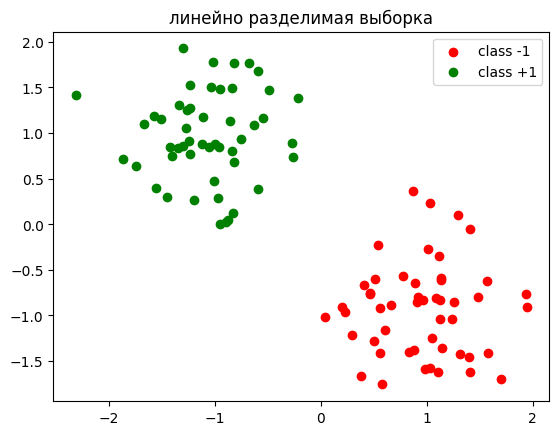

In [ ]:
plt.title('линейно разделимая выборка')
plt.scatter(X[:, 0][y==-1], X[:, 1][y==-1], c='red')
plt.scatter(X[:, 0][y==1], X[:, 1][y==1], c='green')
plt.legend(['class -1', 'class +1'])
plt.show()

In [ ]:
# мажоранты
def sigmoid_loss(M):
  return 1 / ( 1 + jnp.exp(M) )

def hinge_loss(M):
  return jnp.where(1 - M > 0, 1 - M, 0)

def adaline(M):
  return (1 - M)**2

In [ ]:
class LinearClassifier:
  def __init__(self, loss):
    # список функций потерь loss(M), где M = y * (np.dot(X, w) + b)
    self.__loss = loss
    # для проверки того что экземпляр обучен
    self.__fitted = False
    # хранит потери на каждом шаге обучения
    self.losses_ = []

  def get_weights(self):
    return self.__weights

  def get_bias(self):
    return self.__bias

  def predict(self, X):
    if not self.__fitted:
      print('Данный экземпляр еще не обучен, используйте метод fit')
      return

    return jnp.sign( jnp.dot(X, self.__weights) + self.__bias )

  def fit(self, X, y, learning_rate=1e-4, smoothing_rate=0.01, stop_treshold=1e-6, max_iter=1000, visualize_decision=False):
    self.__weights = np.random.normal(0, 1, X.shape[1])
    self.__bias = np.random.normal(0, 1)

    self.__fitted = True

    # явная зависимость loss от __weights и __bias
    loss_of_weights = lambda weights, bias: jnp.mean(  self.__loss( y * (jnp.dot(X, weights) + bias) )  )
    # градиент функции потерь по весам
    auto_grad = grad(loss_of_weights, argnums=(0,1))

    # начальное значение функционала качества
    M = y * (jnp.dot(X, self.__weights) + self.__bias)
    Q = jnp.mean( self.__loss(M) )
    self.losses_.append(Q)

    if visualize_decision:
      # для разделяющих прямых
      _, ax = plt.subplots()
      plt.xlim([np.min(X[:, 0]) - 1, np.max(X[:, 0]) + 1])
      plt.ylim([np.min(X[:, 1]) - 1, np.max(X[:, 1]) + 1])
      plot_points = np.linspace(-100, 100, 200)

    # градиентный спуск
    for i in range(max_iter):
      # вычисление градиента функции потерь в точке (self.__weights, self.__bias)
      dw, db = auto_grad(self.__weights, self.__bias)

      # обновление параметров
      self.__weights -= learning_rate * dw
      self.__bias -= learning_rate * db

      # пересчет функционала качества
      M = y * (jnp.dot(X, self.__weights) + self.__bias)
      Q = smoothing_rate * jnp.mean( self.__loss(M) ) + (1 - smoothing_rate) * Q
      self.losses_.append(Q)

      # строим график разделяющей поверхности каждые 10 шагов
      if visualize_decision and i % 10 == 0:
        ax.plot(self.__weights[1] * plot_points, -self.__weights[0] * plot_points - self.__bias / self.__weights[1], c = 'black', linewidth = 0.5)

      if self.losses_[-2] - self.losses_[-1] < stop_treshold:
        break

    if visualize_decision:
      # обучающие данные и итоговая разделяющая поверхность
      ax.plot(self.__weights[1] * plot_points, -self.__weights[0] * plot_points - self.__bias / self.__weights[1], c = 'blue', linewidth = 5)
      ax.scatter(X[:, 0][y==-1], X[:, 1][y==-1], c='red')
      ax.scatter(X[:, 0][y==1], X[:, 1][y==1], c='green')
      #plt.legend(['class -1', 'class +1'])
      plt.show()

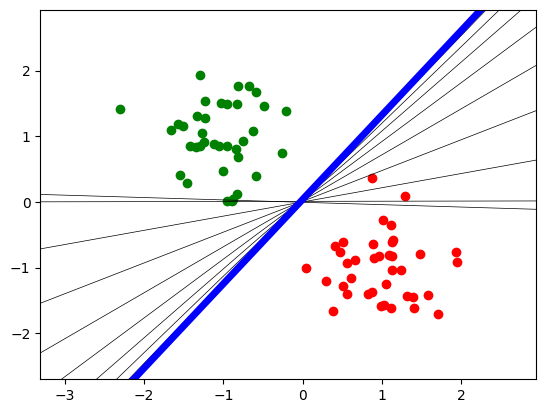

In [ ]:
# adaline
loss = adaline
learning_rate = 1e-1
smoothing_rate = 1e-1
stop_treshold = 1e-4
max_iter = 5000
visualize_decision = True


adaline_clf = LinearClassifier(loss)
adaline_clf.fit(X_train,
                y_train,
                learning_rate=learning_rate,
                smoothing_rate=smoothing_rate,
                stop_treshold=stop_treshold,
                max_iter=max_iter,
                visualize_decision=visualize_decision)

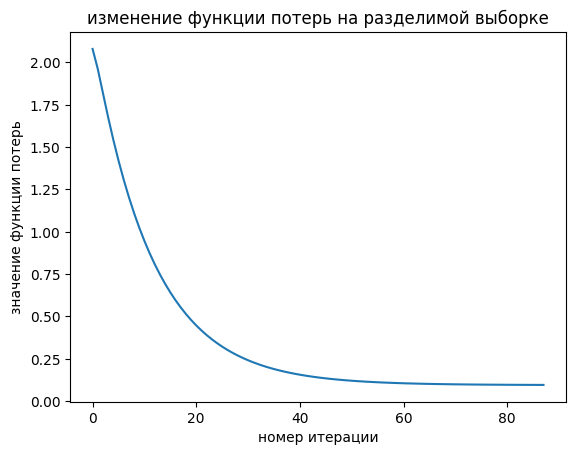

In [ ]:
plt.title('изменение функции потерь на разделимой выборке')
plt.xlabel('номер итерации')
plt.ylabel('значение функции потерь')

plt.plot(np.arange(len(adaline_clf.losses_)), adaline_clf.losses_)

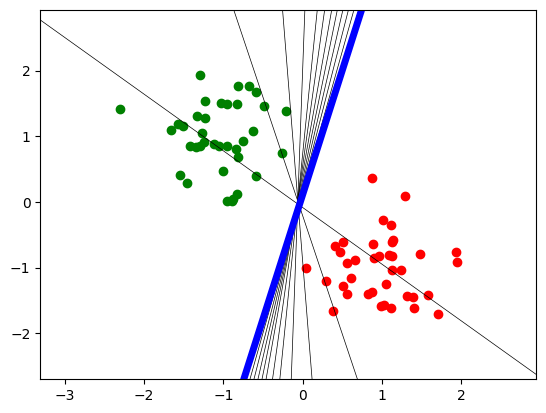

In [ ]:
# svm
loss = hinge_loss

hinge_clf = LinearClassifier(loss)
hinge_clf.fit(X_train,
                y_train,
                learning_rate=learning_rate,
                smoothing_rate=smoothing_rate,
                stop_treshold=stop_treshold,
                max_iter=max_iter,
                visualize_decision=visualize_decision)

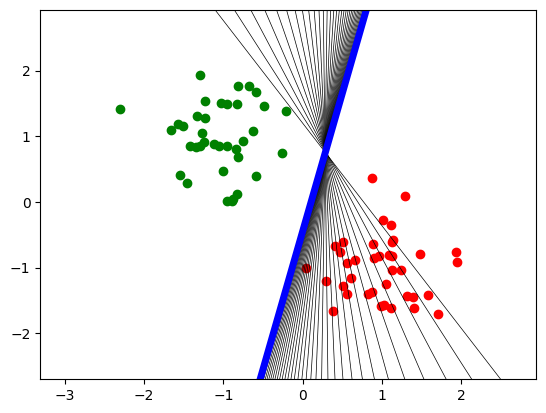

In [ ]:
# sigmoid
loss = sigmoid_loss

sigmoid_clf = LinearClassifier(loss)
sigmoid_clf.fit(X_train,
                y_train,
                learning_rate=learning_rate,
                smoothing_rate=smoothing_rate,
                stop_treshold=stop_treshold,
                max_iter=max_iter,
                visualize_decision=visualize_decision)

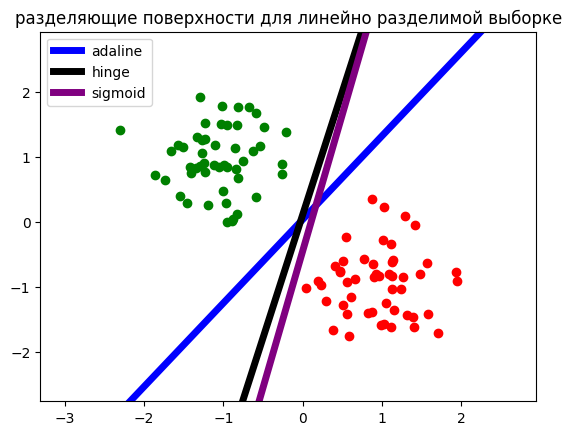

In [ ]:
ada_weights = adaline_clf.get_weights()
ada_bias = adaline_clf.get_bias()

hinge_weights = hinge_clf.get_weights()
hinge_bias = hinge_clf.get_bias()

sigmoid_weights = sigmoid_clf.get_weights()
sigmoid_bias = sigmoid_clf.get_bias()

plot_points = np.linspace(-100, 100, 200)

fig, ax = plt.subplots()
plt.title('разделяющие поверхности для линейно разделимой выборке')

# отображаем выборку
ax.scatter(X[:, 0][y==-1], X[:, 1][y==-1], c='red')
ax.scatter(X[:, 0][y==1], X[:, 1][y==1], c='green')
plt.xlim([np.min(X[:, 0]) - 1, np.max(X[:, 0]) + 1])
plt.ylim([np.min(X[:, 1]) - 1, np.max(X[:, 1]) + 1])

# отображаем поверхности
ada_line, = ax.plot(ada_weights[1] * plot_points,
                    -ada_weights[0] * plot_points - ada_bias / ada_weights[1],
                    c = 'blue',
                    linewidth = 5,
                    label='adaline')

hinge_line, = ax.plot(hinge_weights[1] * plot_points,
                      -hinge_weights[0] * plot_points - hinge_bias / hinge_weights[1],
                      c = 'black',
                      linewidth = 5,
                      label='hinge')

sigmoid_line, = ax.plot(sigmoid_weights[1] * plot_points,
                        -sigmoid_weights[0] * plot_points - sigmoid_bias / sigmoid_weights[1],
                        c = 'purple',
                        linewidth = 5,
                        label='sigmoid')

plt.legend(handles=[ada_line, hinge_line, sigmoid_line])
plt.show()

In [ ]:
X_nondiv, y_nondiv = generate_dataset([-0.4,0.4], [0.4,-0.4], 0.5, 0.5, 50, 50)
X_train_nondiv, X_test_nondiv, y_train_nondiv, y_test_nondiv = train_test_split(X_nondiv, y_nondiv)

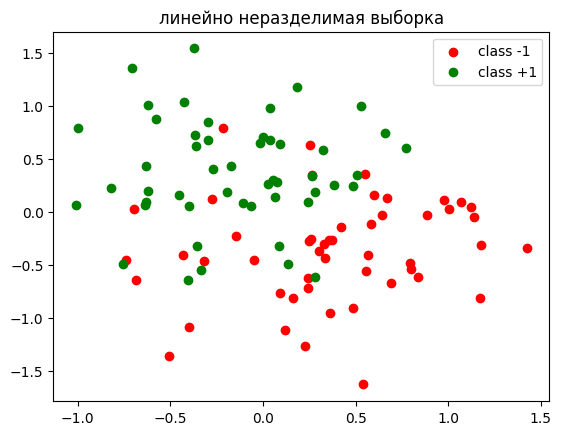

In [ ]:
plt.title('линейно неразделимая выборка')
plt.scatter(X_nondiv[:, 0][y_nondiv==-1], X_nondiv[:, 1][y_nondiv==-1], c='red')
plt.scatter(X_nondiv[:, 0][y_nondiv==1], X_nondiv[:, 1][y_nondiv==1], c='green')
plt.legend(['class -1', 'class +1'])
plt.show()

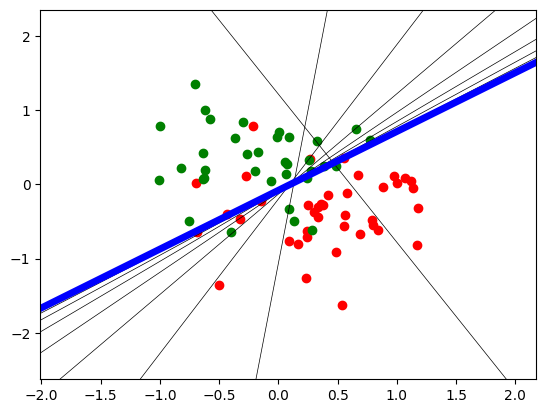

In [ ]:
# adaline
adaline_clf_nondiv = LinearClassifier(loss=adaline)
adaline_clf_nondiv.fit(X_train_nondiv,
                      y_train_nondiv,
                      learning_rate=learning_rate,
                      smoothing_rate=smoothing_rate,
                      stop_treshold=stop_treshold,
                      max_iter=max_iter,
                      visualize_decision=visualize_decision)

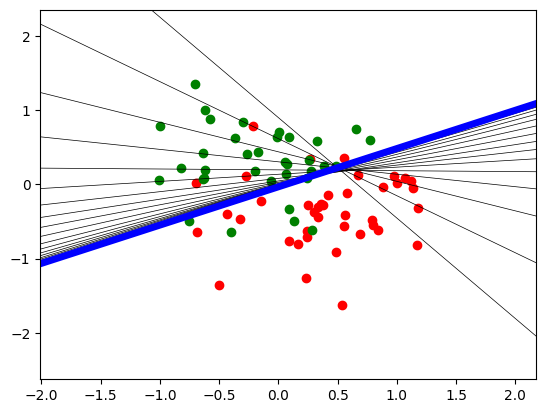

In [ ]:
# hinge
hinge_clf_nondiv = LinearClassifier(loss=hinge_loss)
hinge_clf_nondiv.fit(X_train_nondiv,
                      y_train_nondiv,
                      learning_rate=learning_rate,
                      smoothing_rate=smoothing_rate,
                      stop_treshold=stop_treshold,
                      max_iter=max_iter,
                      visualize_decision=visualize_decision)

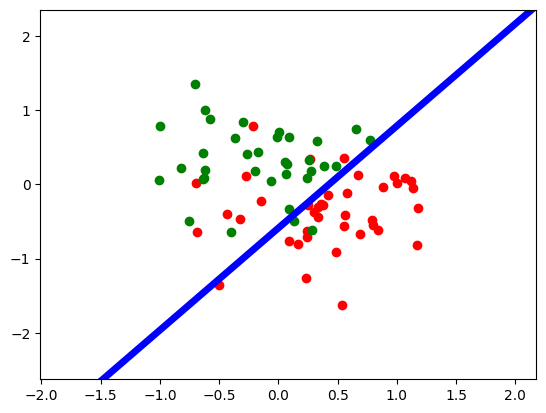

In [ ]:
# sigmoid
sigmoid_clf_nondiv = LinearClassifier(loss=sigmoid_loss)
sigmoid_clf_nondiv.fit(X_train_nondiv,
                      y_train_nondiv,
                      learning_rate=learning_rate,
                      smoothing_rate=smoothing_rate,
                      stop_treshold=stop_treshold,
                      max_iter=max_iter,
                      visualize_decision=visualize_decision)

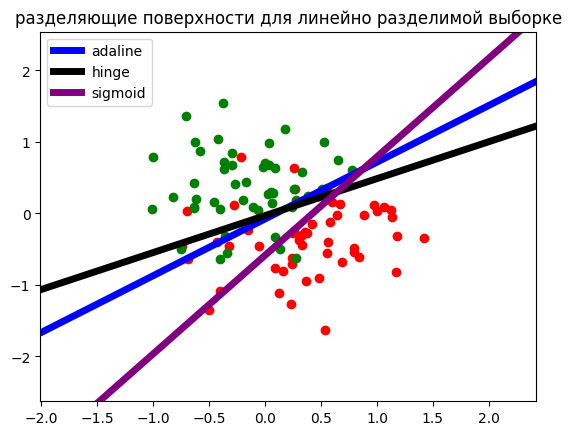

In [ ]:
ada_weights_nondiv = adaline_clf_nondiv.get_weights()
ada_bias_nondiv = adaline_clf_nondiv.get_bias()

hinge_weights_nondiv = hinge_clf_nondiv.get_weights()
hinge_bias_nondiv = hinge_clf_nondiv.get_bias()

sigmoid_weights_nondiv = sigmoid_clf_nondiv.get_weights()
sigmoid_bias_nondiv = sigmoid_clf_nondiv.get_bias()

plot_points = np.linspace(-100, 100, 200)

fig, ax = plt.subplots()
plt.title('разделяющие поверхности для линейно разделимой выборке')

# отображаем выборку
ax.scatter(X_nondiv[:, 0][y_nondiv==-1], X_nondiv[:, 1][y_nondiv==-1], c='red')
ax.scatter(X_nondiv[:, 0][y_nondiv==1], X_nondiv[:, 1][y_nondiv==1], c='green')
plt.xlim([np.min(X_nondiv[:, 0]) - 1, np.max(X_nondiv[:, 0]) + 1])
plt.ylim([np.min(X_nondiv[:, 1]) - 1, np.max(X_nondiv[:, 1]) + 1])

# отображаем поверхности
ada_line_nondiv, = ax.plot(ada_weights_nondiv[1] * plot_points,
                          -ada_weights_nondiv[0] * plot_points - ada_bias_nondiv / ada_weights_nondiv[1],
                          c = 'blue',
                          linewidth = 5,
                          label='adaline')

hinge_line_nondiv, = ax.plot(hinge_weights_nondiv[1] * plot_points,
                            -hinge_weights_nondiv[0] * plot_points - hinge_bias_nondiv / hinge_weights_nondiv[1],
                            c = 'black',
                            linewidth = 5,
                            label='hinge')

sigmoid_line_nondiv, = ax.plot(sigmoid_weights_nondiv[1] * plot_points,
                              -sigmoid_weights_nondiv[0] * plot_points - sigmoid_bias_nondiv / sigmoid_weights_nondiv[1],
                              c = 'purple',
                              linewidth = 5,
                              label='sigmoid')

plt.legend(handles=[ada_line_nondiv, hinge_line_nondiv, sigmoid_line_nondiv])
plt.show()